# Esercitazione 10
## Campionamento di segnali
#### Sommario
In questa esercitazione vengono introdotti alcuni concetti fondamentali legati al campionamento di segnali, con particolare attenzione ai fenomeni di aliasing e sottocampionamento. Nella prima parte (esercizio 1 e 2) si studia l’impatto del sottocampionamento nel dominio della frequenza tramite l’analisi della DFT di un segnale. Infine, si discuteranno i risultati del teorema del campionamento, si applicheranno i concetti appresi a un segnale audio reale (esercizio 3) e si dimostrerà l’efficacia dell’applicazione di un filtro passa basso per mitigare gli effetti dell’aliasing.



In [8]:
import numpy as np
import matplotlib.pylab as plt 
from scipy import fftpack as f
import scipy.io.wavfile
import scipy.io as sio

#### Esercizio 1 -> Sampling, Down-sampling, Aliasing

(a) Considerare il seguente segnale:

$$x(t) = \mathrm{sinc}^2(t),$$

dove $t$ è un vettore di 1000 punti equispaziati da $-25$ a $25$. Fare un plot di $x(t)$.

(b) Calcolare la DFT di $x(t)$ e fare un plot del valore assoluto dei coefficienti ottenuti. Che tipo di filtro è $x(t)$?

(c) Sottocampionare il segnale $x(t)$ di un fattore 5. Calcolare la DFT del segnale sottocampionato e fare un plot del valore assoluto dei coefficienti ottenuti.

(d) Ripetere il punto precedente utilizzando prima un fattore 10 e poi un fattore 20. Che differenze si possono notare?

(e) Ricostruire il segnale $x(t)$ a partire dallo spettro del segnale sottocampionato di un fattore 5. Per ricostruire il segnale, utilizzare lo zero padding nel dominio delle frequenze (NB: applicare lo zero padding nel centro dello spettro). Fare un plot del segnale ricostruito e confrontarlo con il segnale originale.

(f) Ripetere il punto precedente utilizzando prima il segnale sottocampionato di un fattore 10 e poi di un fattore 20. Che differenze si possono notare?


== (a) Definizione del segnale ==


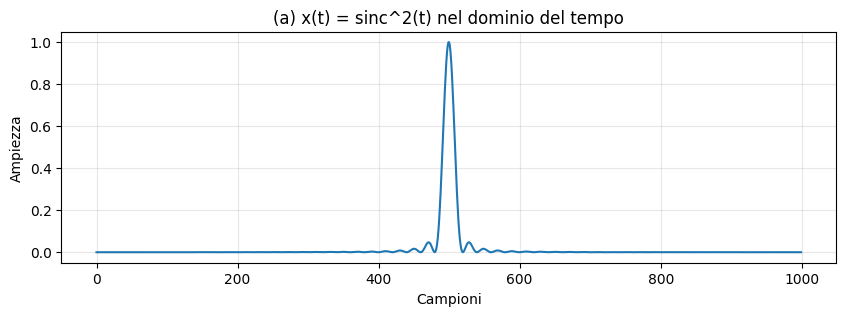

== (b) DFT di x(t) e commento sul tipo di filtro ==


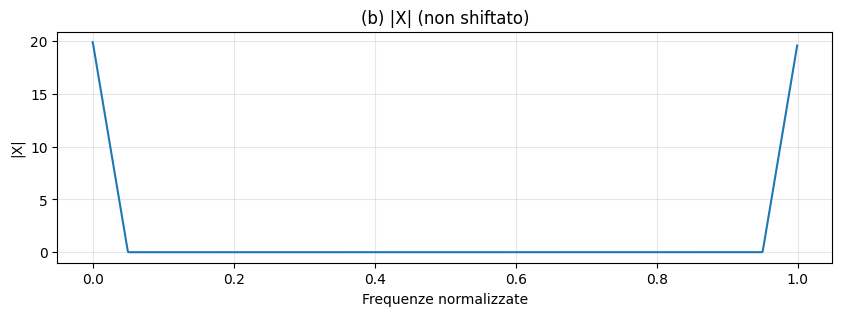

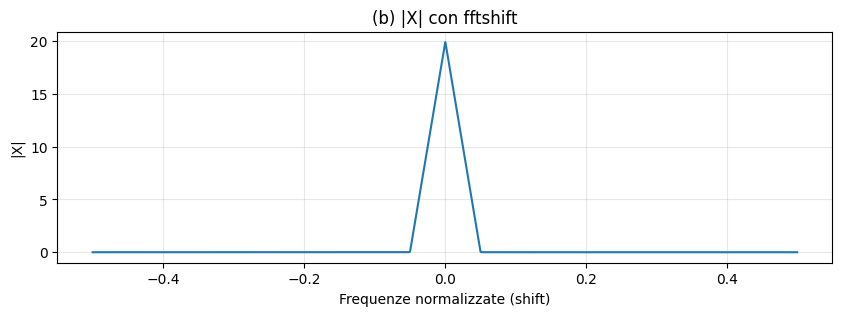

Osservazione: x(t)=sinc^2(t) è lobi centrati in frequenza; nel dominio della frequenza il modulo è una funzione a campana concentrata attorno a 0 -> comportamento da filtro passa-basso in tempo discreto.
== (c) Sottocampionamento di fattore 5 ==
[Downsampling] Fattore m=5 | Lunghezza originale=1000, sottocampionata=200


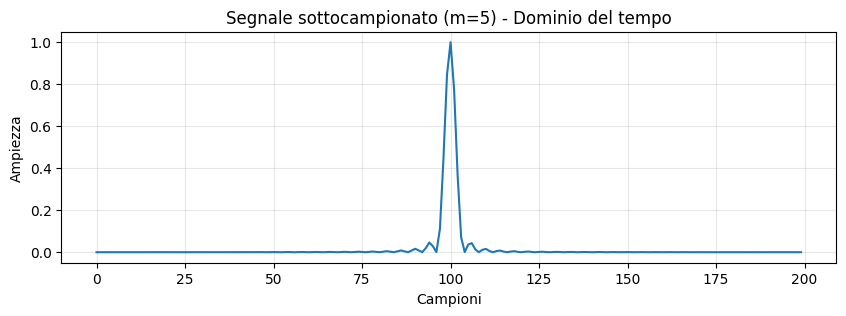

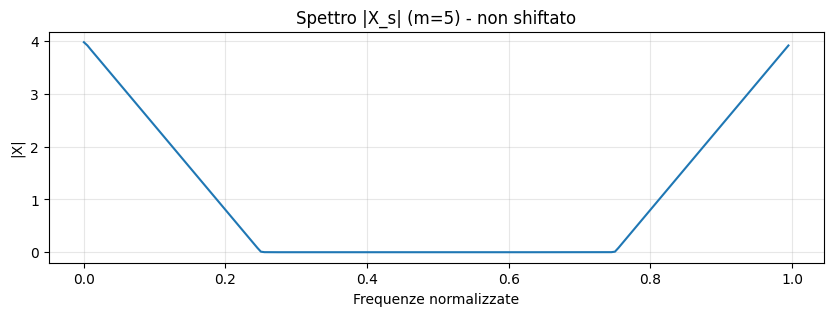

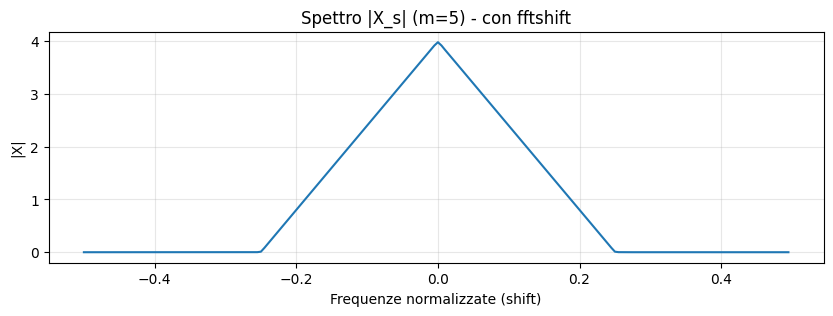

== (d) Sottocampionamento di fattore 10 ==
[Downsampling] Fattore m=10 | Lunghezza originale=1000, sottocampionata=100


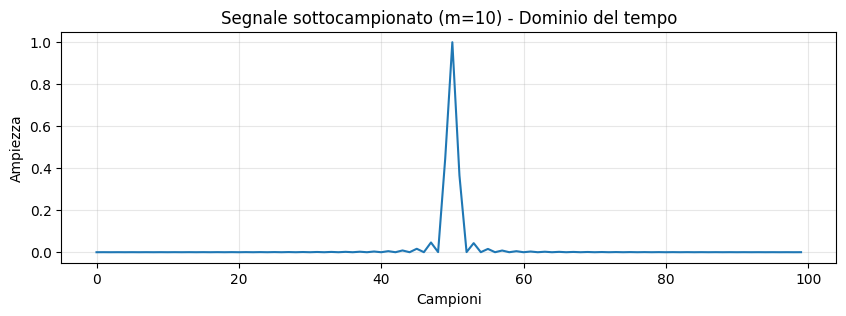

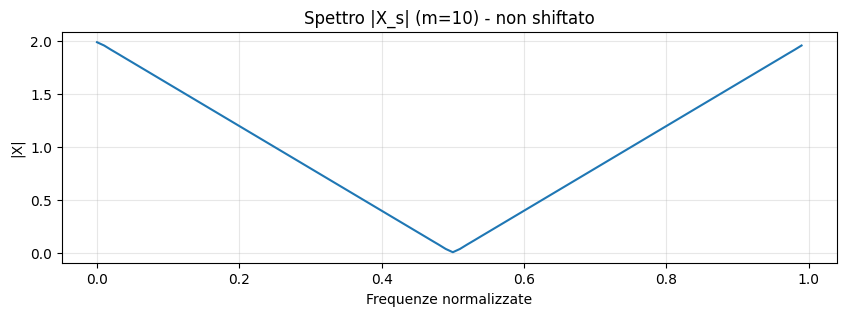

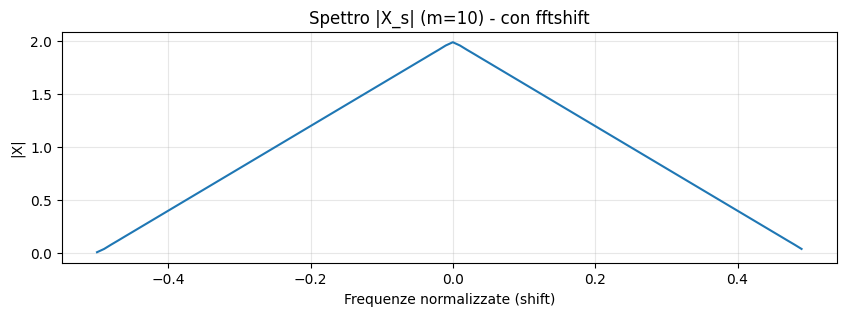

== (d) Sottocampionamento di fattore 20 ==
[Downsampling] Fattore m=20 | Lunghezza originale=1000, sottocampionata=50


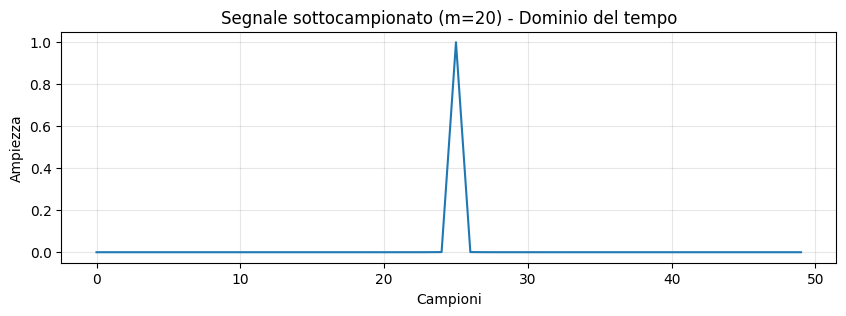

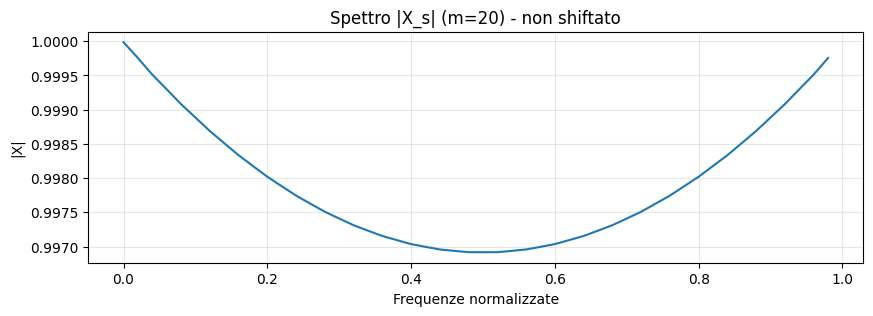

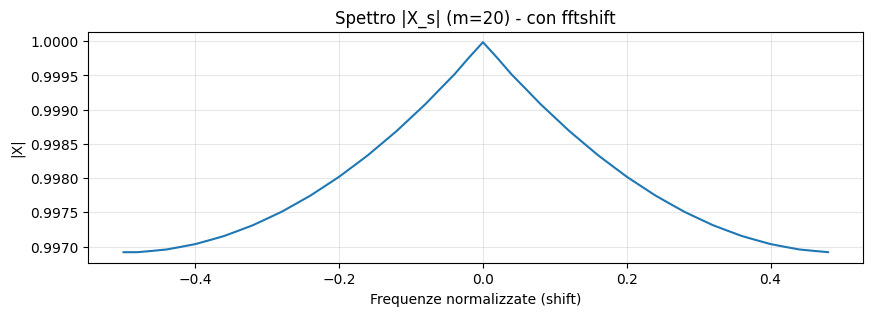

== (e) Ricostruzione da m=5 con zero-padding al centro dello spettro ==
[Ricostruzione m=5] N_target=1000, Ns=200, scaling=5.000 | MSE=8.4693e-14


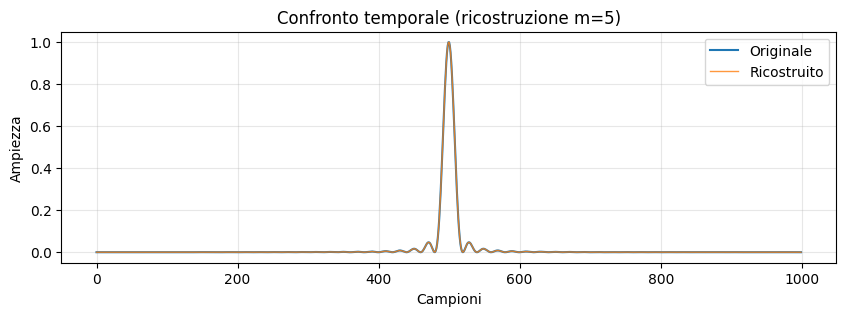

== (f) Ricostruzione da m=10 con zero-padding al centro dello spettro ==
[Ricostruzione m=10] N_target=1000, Ns=100, scaling=10.000 | MSE=3.4155e-10


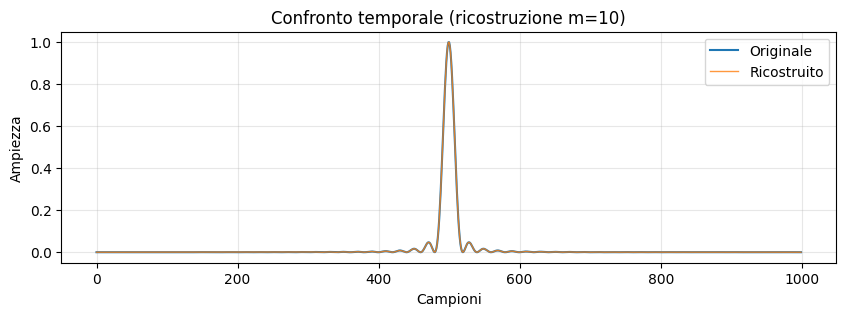

== (f) Ricostruzione da m=20 con zero-padding al centro dello spettro ==
[Ricostruzione m=20] N_target=1000, Ns=50, scaling=20.000 | MSE=3.1439e-03


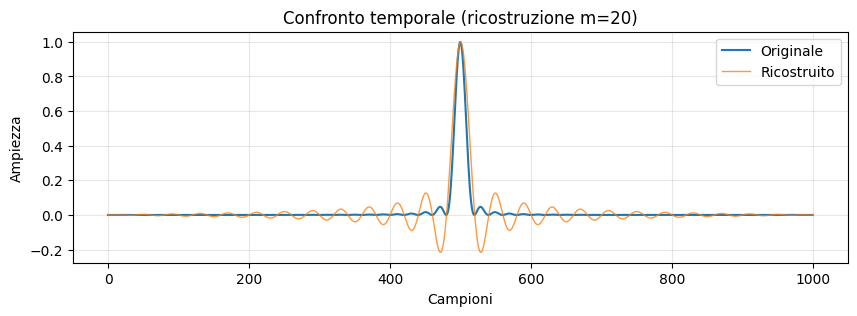

In [9]:
# ===========================
# Esercizio 1 -> Sampling, Down-sampling, Aliasing
# ===========================
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as f

# ---------------------------
# Utility per plotting
# ---------------------------
def plot_time(x, title="Segnale nel tempo"):
    plt.figure(figsize=(10, 3))
    plt.plot(x)
    plt.title(title)
    plt.xlabel('Campioni')
    plt.ylabel('Ampiezza')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_fft(X, title="Spettro |X| (non shiftato)"):
    """Mostra modulo della FFT non shiftata con asse di frequenza normalizzato [0,1)."""
    N = X.size
    norm_freq = np.arange(N, dtype=float) / float(N)
    plt.figure(figsize=(10, 3))
    plt.plot(norm_freq, np.abs(X))
    plt.title(title)
    plt.xlabel('Frequenze normalizzate')
    plt.ylabel('|X|')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_fft_shifted(X, title="Spettro |X| con fftshift"):
    """Mostra modulo della FFT shiftata (DC al centro) con asse di frequenza [-0.5, 0.5)."""
    N = X.size
    Xs = f.fftshift(X)
    freq = np.fft.fftshift(np.fft.fftfreq(N, d=1.0))  # asse normalizzato
    plt.figure(figsize=(10, 3))
    plt.plot(freq, np.abs(Xs))
    plt.title(title)
    plt.xlabel('Frequenze normalizzate (shift)')
    plt.ylabel('|X|')
    plt.grid(True, alpha=0.3)
    plt.show()

# ---------------------------
# (c-d) Downsampling e FFT
# ---------------------------
def downsampling(x, m, show_plots=True):
    """
    Sottocampiona x di fattore m e mostra lo spettro del segnale sottocampionato.
    Restituisce (Dx, X_Dx).
    """
    n = len(x)
    Dx = x[0:n:m]
    X_Dx = f.fft(Dx)
    if show_plots:
        print(f"[Downsampling] Fattore m={m} | Lunghezza originale={n}, sottocampionata={Dx.size}")
        plot_time(Dx, title=f'Segnale sottocampionato (m={m}) - Dominio del tempo')
        plot_fft(X_Dx, title=f'Spettro |X_s| (m={m}) - non shiftato')
        plot_fft_shifted(X_Dx, title=f'Spettro |X_s| (m={m}) - con fftshift')
    return Dx, X_Dx

# ---------------------------
# (e-f) Ricostruzione con zero padding al centro dello spettro
# ---------------------------
def zero_padding_and_invert(X_s, N_target, show_plots=True, x_ref=None, label='m=?'):
    """
    Ricostruisce un segnale di lunghezza N_target a partire da X_s (DFT corta).
    Esegue zero-padding al centro dello spettro usando fftshift/ifftshift.
    Applica uno scaling (N_target / len(X_s)) per compensare la differenza di lunghezze.
    Se x_ref è fornito, calcola e stampa MSE.
    Restituisce xx (ricostruito).
    """
    Ns = X_s.size
    # Spettro centrato
    Xs_shift = f.fftshift(X_s)
    # Zero padding al centro
    pad = N_target - Ns
    if pad < 0:
        raise ValueError("N_target deve essere >= len(X_s).")
    left_pad = pad // 2
    right_pad = pad - left_pad
    Xp_shift = np.pad(Xs_shift, (left_pad, right_pad), mode='constant')
    # Torna non shiftato e IFFT con scaling per compensare la diversa lunghezza
    Xp = f.ifftshift(Xp_shift)
    scaling = float(N_target) / float(Ns)
    xx = scaling * np.real(f.ifft(Xp))

    if show_plots:
        if x_ref is not None:
            mse = np.mean((xx - x_ref)**2)
            print(f"[Ricostruzione {label}] N_target={N_target}, Ns={Ns}, scaling={scaling:.3f} | MSE={mse:.4e}")
        else:
            print(f"[Ricostruzione {label}] N_target={N_target}, Ns={Ns}, scaling={scaling:.3f}")
        # Confronto temporale
        if x_ref is not None:
            plt.figure(figsize=(10, 3))
            plt.plot(x_ref, label='Originale', linewidth=1.5)
            plt.plot(xx, label='Ricostruito', linewidth=1.0, alpha=0.8)
            plt.title(f'Confronto temporale (ricostruzione {label})')
            plt.xlabel('Campioni')
            plt.ylabel('Ampiezza')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

    return xx

# ===========================
# (a) Segnale x(t) = sinc^2(t), t in [-25, 25] con 1000 punti
# ===========================
print("== (a) Definizione del segnale ==")
t = np.linspace(-25, 25, 1000)
x = (np.sinc(t))**2  # np.sinc: sin(pi t)/(pi t)

plot_time(x, title='(a) x(t) = sinc^2(t) nel dominio del tempo')

# ===========================
# (b) DFT di x(t) e tipo di filtro
# ===========================
print("== (b) DFT di x(t) e commento sul tipo di filtro ==")
X = f.fft(x)
plot_fft(X, title='(b) |X| (non shiftato)')
plot_fft_shifted(X, title='(b) |X| con fftshift')

print("Osservazione: x(t)=sinc^2(t) è lobi centrati in frequenza; nel dominio della frequenza il modulo è una funzione a campana concentrata attorno a 0 -> comportamento da filtro passa-basso in tempo discreto.")

# ===========================
# (c) Sottocampionamento fattore 5
# ===========================
print("== (c) Sottocampionamento di fattore 5 ==")
x_s5, X_s5 = downsampling(x, 5, show_plots=True)

# ===========================
# (d) Sottocampionamento fattori 10 e 20
# ===========================
print("== (d) Sottocampionamento di fattore 10 ==")
x_s10, X_s10 = downsampling(x, 10, show_plots=True)

print("== (d) Sottocampionamento di fattore 20 ==")
x_s20, X_s20 = downsampling(x, 20, show_plots=True)

# ===========================
# (e) Ricostruzione da spettro sottocampionato (fattore 5)
#     Zero padding centrato nello spettro e confronto
# ===========================
print("== (e) Ricostruzione da m=5 con zero-padding al centro dello spettro ==")
xx5 = zero_padding_and_invert(X_s5, N_target=len(x), show_plots=True, x_ref=x, label='m=5')

# ===========================
# (f) Ricostruzione da m=10 e m=20
# ===========================
print("== (f) Ricostruzione da m=10 con zero-padding al centro dello spettro ==")
xx10 = zero_padding_and_invert(X_s10, N_target=len(x), show_plots=True, x_ref=x, label='m=10')

print("== (f) Ricostruzione da m=20 con zero-padding al centro dello spettro ==")
xx20 = zero_padding_and_invert(X_s20, N_target=len(x), show_plots=True, x_ref=x, label='m=20')


#### Esercizio 2 -> Ascoltare l'aliasing

(a) Considerare il segnale $y = [y_1\ z\ y_2\ z\ y_3]$, dove $z$ è un vettore di zeri di lunghezza 1000 e $y_1, y_2$ e $y_3$ sono definiti come:

$$y_1(t) = \sin\left(\frac{80\pi t}{1000}
\right),\quad y_2(t) = \sin\left(\frac{160\pi t}{1000}
\right),\quad y_3(t) = \sin\left(\frac{320\pi t}{1000}
\right),$$

dove $t$ è un vettore di 1000 punti equispaziati da $0$ a $999$. Salvare il segnale $y$ come file audio utilizzando una frequenza di campionamento di 9000 Hz.

(b) Calcolare la DFT di $y$ e fare un plot del valore assoluto dei coefficienti ottenuti.

(c) Sottocampionare il segnale $y$ di un fattore 2 e calcolare la DFT del segnale sottocampionato. Fare un plot del valore assoluto dei coefficienti ottenuti. Ricostruire il segnale utilizzando lo zero padding. Salvare il segnale ricostruito come file audio e provare ad ascoltarlo.

(d) Ripetere il punto precedente sottocampionando il segnale di un fattore 10. Che differenze si possono notare?


== (a) Definizione del segnale y ==


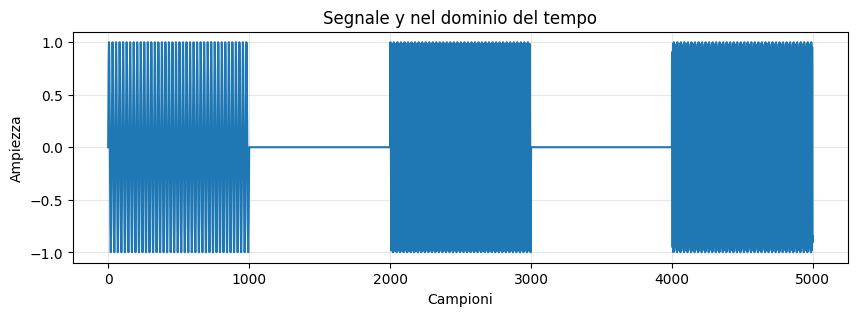

File 'sound_orig.wav' salvato (Fs = 9000 Hz)
== (b) Spettro del segnale originale ==


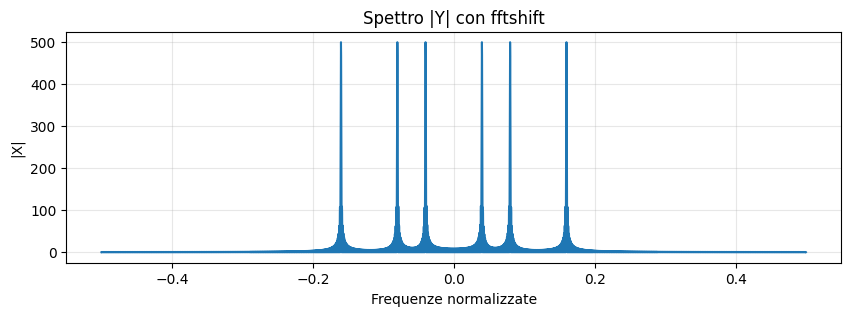

== (c) Sottocampionamento di fattore 2 ==


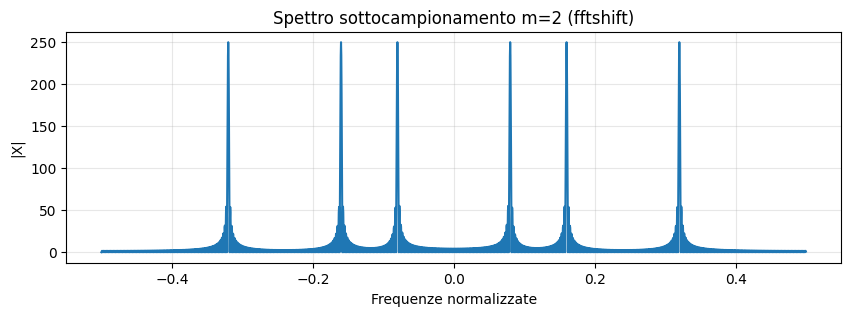

[Ricostruzione m=2] MSE = 6.9769e-05
Confronto spettri originale vs ricostruito (m=2)


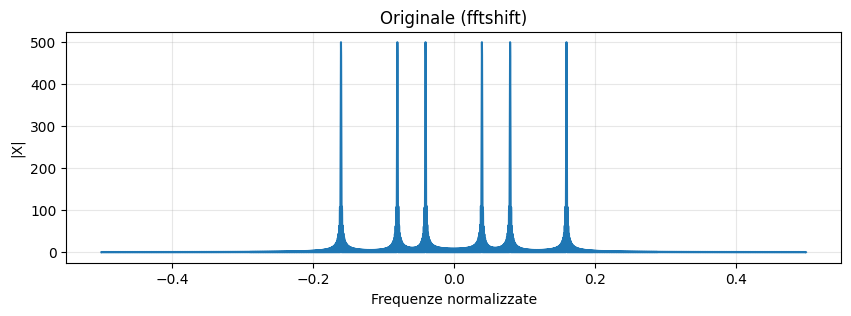

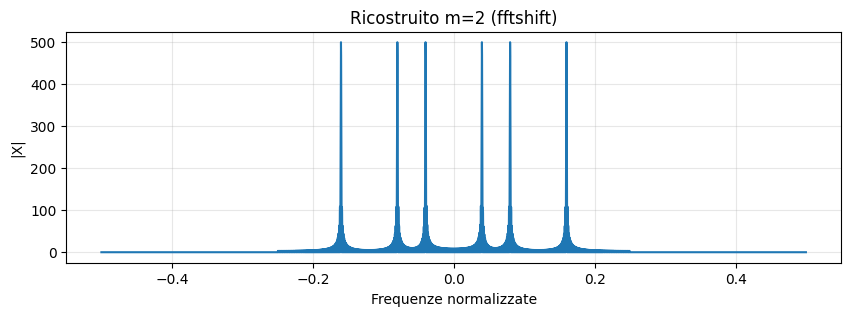

File 'sound_s2.wav' salvato (Fs = 9000 Hz)
== (d) Sottocampionamento di fattore 10 ==


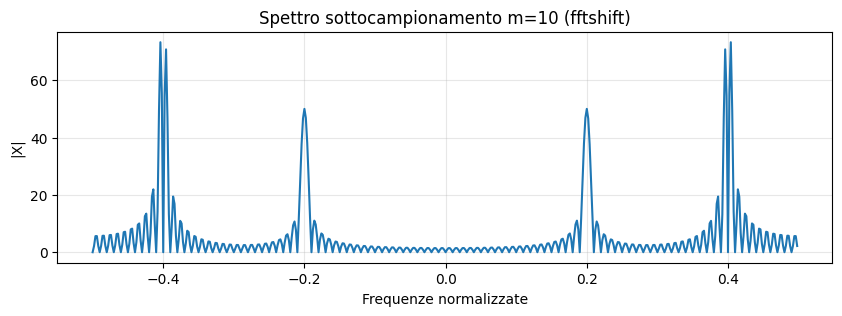

[Ricostruzione m=10] MSE = 4.0112e-01
Confronto spettri originale vs ricostruito (m=10)


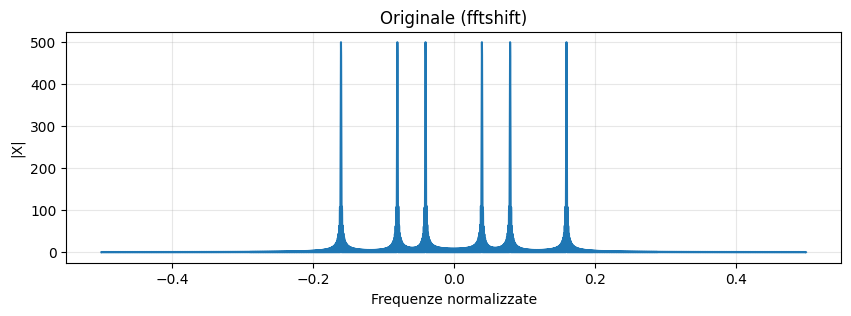

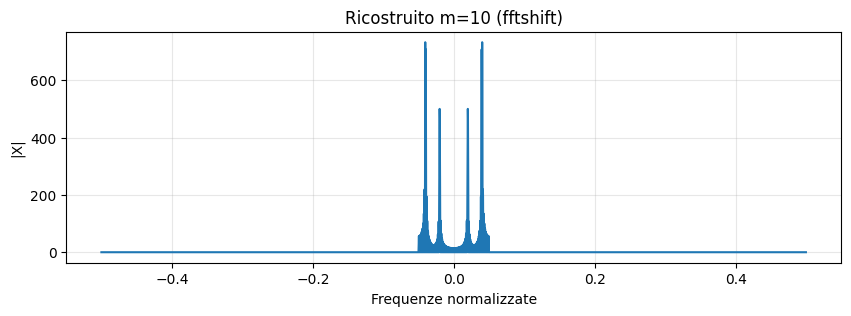

File 'sound_s10.wav' salvato (Fs = 9000 Hz)

Osservazione: per m=10 si nota un aliasing molto più marcato rispetto a m=2, sia nello spettro che nell'audio ricostruito.


In [10]:
# ===========================
# Esercizio 2 -> Ascoltare l'aliasing
# ===========================
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as f
import scipy.io.wavfile as wav

# ---------------------------
# Funzioni di supporto
# ---------------------------
def plot_time(x, title="Segnale nel tempo"):
    plt.figure(figsize=(10, 3))
    plt.plot(x)
    plt.title(title)
    plt.xlabel('Campioni')
    plt.ylabel('Ampiezza')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_fft(X, title="Spettro |X|", shift=True):
    N = X.size
    if shift:
        Xp = f.fftshift(X)
        freq = np.fft.fftshift(np.fft.fftfreq(N, d=1.0))
    else:
        Xp = X
        freq = np.arange(N) / N
    plt.figure(figsize=(10, 3))
    plt.plot(freq, np.abs(Xp))
    plt.title(title)
    plt.xlabel('Frequenze normalizzate' if shift else 'Indice')
    plt.ylabel('|X|')
    plt.grid(True, alpha=0.3)
    plt.show()

def zero_padding_reconstruct(X_s, N_target, x_ref=None, label=''):
    """
    Ricostruzione via zero padding centrato nello spettro.
    """
    Ns = X_s.size
    Xs_shift = f.fftshift(X_s)
    pad_total = N_target - Ns
    left_pad = pad_total // 2
    right_pad = pad_total - left_pad
    Xp_shift = np.pad(Xs_shift, (left_pad, right_pad), mode='constant')
    Xp = f.ifftshift(Xp_shift)

    scaling = float(N_target) / float(Ns)
    xx = scaling * np.real(f.ifft(Xp))

    if x_ref is not None:
        mse = np.mean((xx - x_ref)**2)
        print(f"[Ricostruzione {label}] MSE = {mse:.4e}")

    return xx

# ===========================
# (a) Definizione del segnale y
# ===========================
print("== (a) Definizione del segnale y ==")
t = np.linspace(0, 999, 1000)
y1 = np.sin((t * 2 * np.pi * 40) / 1000)
y2 = np.sin((t * 2 * np.pi * 80) / 1000)
y3 = np.sin((t * 2 * np.pi * 160) / 1000)

y = np.concatenate([y1, np.zeros(1000), y2, np.zeros(1000), y3])
plot_time(y, title="Segnale y nel dominio del tempo")

# Salvataggio audio originale
wav.write('sound_orig.wav', 9000, y.astype(np.float32))
print("File 'sound_orig.wav' salvato (Fs = 9000 Hz)")

# ===========================
# (b) DFT di y
# ===========================
print("== (b) Spettro del segnale originale ==")
Y = f.fft(y)
plot_fft(Y, title="Spettro |Y| con fftshift", shift=True)

# ===========================
# (c) Sottocampionamento di fattore 2
# ===========================
print("== (c) Sottocampionamento di fattore 2 ==")
y_s2 = y[::2]
Y_s2 = f.fft(y_s2)
plot_fft(Y_s2, title="Spettro sottocampionamento m=2 (fftshift)", shift=True)

# Ricostruzione con zero padding
yy2 = zero_padding_reconstruct(Y_s2, N_target=len(y), x_ref=y, label='m=2')

# Confronto spettri originale vs ricostruito
print("Confronto spettri originale vs ricostruito (m=2)")
plot_fft(Y, title="Originale (fftshift)", shift=True)
plot_fft(f.fft(yy2), title="Ricostruito m=2 (fftshift)", shift=True)

# Salvataggio audio ricostruito
wav.write('sound_s2.wav', 9000, yy2.astype(np.float32))
print("File 'sound_s2.wav' salvato (Fs = 9000 Hz)")

# ===========================
# (d) Sottocampionamento di fattore 10
# ===========================
print("== (d) Sottocampionamento di fattore 10 ==")
y_s10 = y[::10]
Y_s10 = f.fft(y_s10)
plot_fft(Y_s10, title="Spettro sottocampionamento m=10 (fftshift)", shift=True)

# Ricostruzione con zero padding
yy10 = zero_padding_reconstruct(Y_s10, N_target=len(y), x_ref=y, label='m=10')

# Confronto spettri originale vs ricostruito
print("Confronto spettri originale vs ricostruito (m=10)")
plot_fft(Y, title="Originale (fftshift)", shift=True)
plot_fft(f.fft(yy10), title="Ricostruito m=10 (fftshift)", shift=True)

# Salvataggio audio ricostruito
wav.write('sound_s10.wav', 9000, yy10.astype(np.float32))
print("File 'sound_s10.wav' salvato (Fs = 9000 Hz)")

print("\nOsservazione: per m=10 si nota un aliasing molto più marcato rispetto a m=2, "
      "sia nello spettro che nell'audio ricostruito.")


#### Esercizio 3 -> Down-sampling e teorema del campionamento

(a) Leggere il file `jingle.mat` utilizzando il comando:

```np.squeeze(sio.loadmat('jingle.mat')['jingle'])```

Il file contiene un breve segnale audio. Salvare il segnale audio come file audio utilizzando una frequenza di campionamento di 44000 Hz e provare ad ascoltarlo. Calcolare la DFT del segnale e fare il plot del valore assoluto dei coefficienti.

(b) Sottocampionare il segnale di un fattore 2 e calcolare la DFT del segnale sottocampionato. Fare un plot del valore assoluto dei coefficienti ottenuti. Ricostruire il segnale utilizzando lo zero padding. Salvare il segnale ricostruito come file audio e provare ad ascoltarlo.

(c) Ripetere il punto precedente sottocampionando il segnale di un fattore 10. Che differenze si possono notare?

(d) Per ridurre l’effetto di aliasing quando si sottocampiona di un fattore 10, possiamo ridurre l’informazione iniziale utilizzando un filtro passa basso prima di effettuare il sottocampionamento. Provare ad applicare il seguente filtro passa basso:

$$h(t) = \frac{100\pi}{1000} \; \mathrm{sinc}\left(\frac{100 t}{1000}
\right)$$

In questo caso come cambia la qualità del segnale ricostruito?


== (a) Caricamento e analisi segnale originale ==
File 'jingle.wav' salvato (Fs = 44000 Hz)


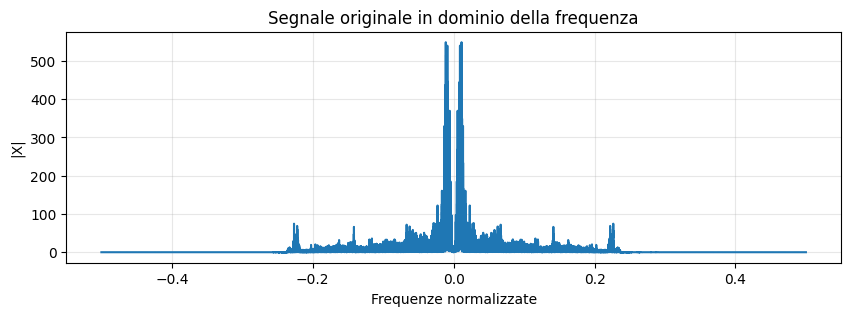

== (b) Sottocampionamento di fattore 2 ==
[Ricostruzione m=2] MSE = 5.9923e-10


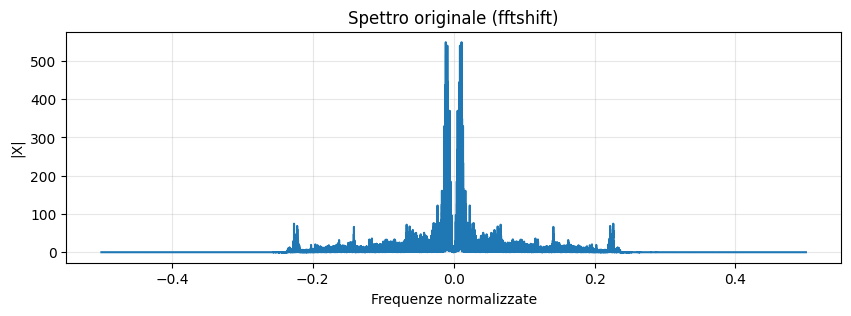

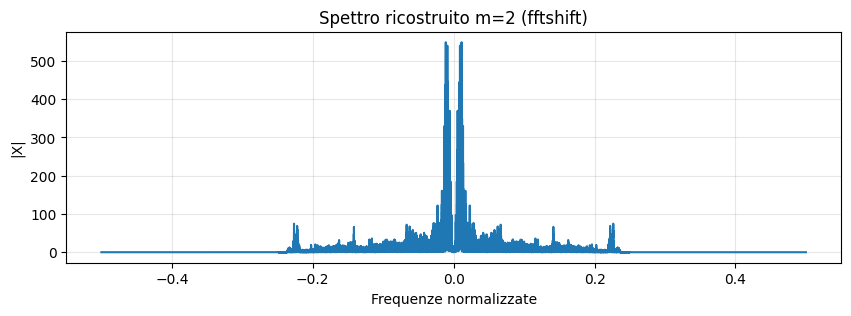

File 'jingle_s2.wav' salvato
== (c) Sottocampionamento di fattore 10 ==
[Ricostruzione m=10] MSE = 2.3543e-04


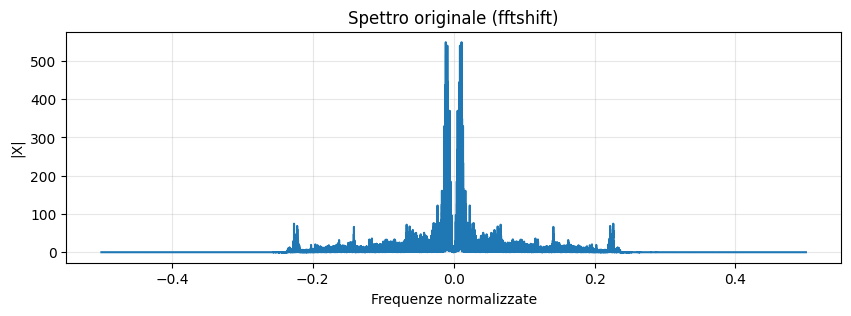

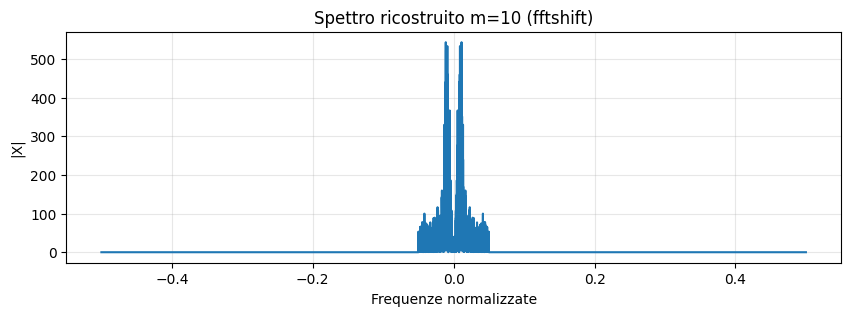

File 'jingle_s10.wav' salvato
== (d) Filtro passa basso prima del sottocampionamento ==


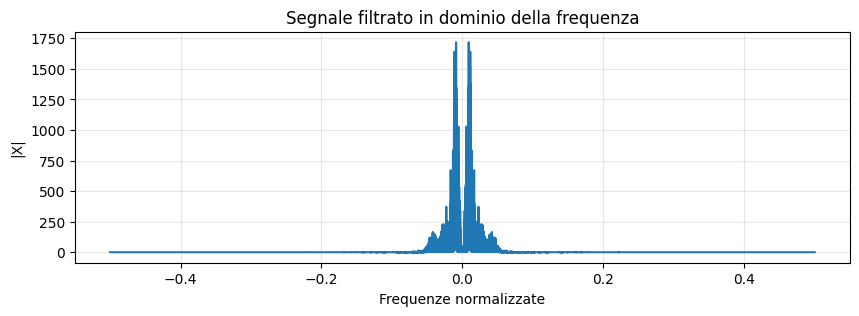

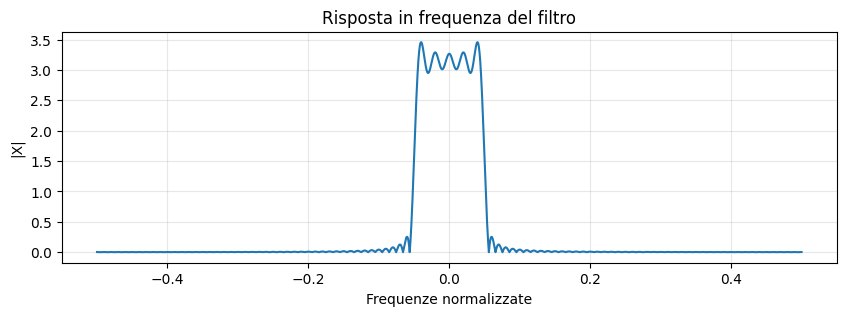

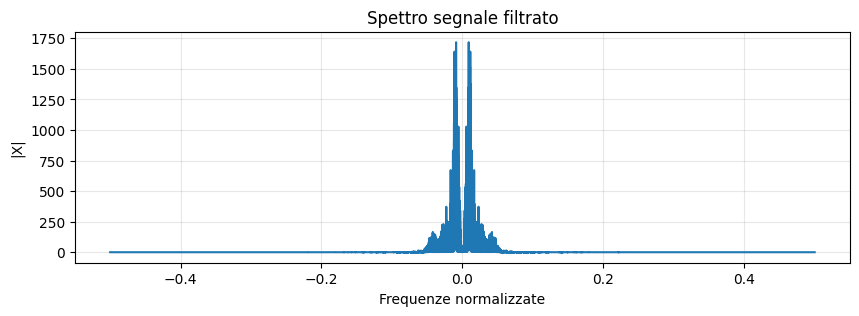

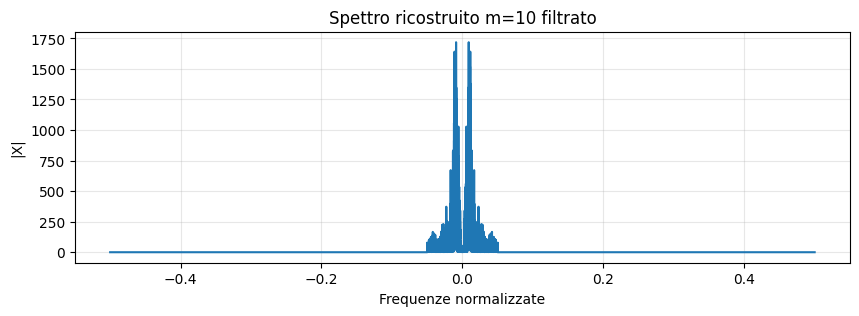

File 'jingle_s10_f.wav' salvato


In [11]:
# ===========================
# Esercizio 3 -> Down-sampling e teorema del campionamento
# ===========================
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as f
import scipy.io as sio
import scipy.io.wavfile as wav

# ---------------------------
# Funzioni di supporto
# ---------------------------
def plot_fft(X, title="Spettro |X|", shift=True):
    N = X.size
    if shift:
        Xp = f.fftshift(X)
        freq = np.fft.fftshift(np.fft.fftfreq(N, d=1.0))
    else:
        Xp = X
        freq = np.arange(N) / N
    plt.figure(figsize=(10, 3))
    plt.plot(freq, np.abs(Xp))
    plt.title(title)
    plt.xlabel('Frequenze normalizzate' if shift else 'Indice')
    plt.ylabel('|X|')
    plt.grid(True, alpha=0.3)
    plt.show()

def zero_padding_reconstruct(X_s, N_target, x_ref=None, label=''):
    Ns = X_s.size
    Xs_shift = f.fftshift(X_s)
    pad_total = N_target - Ns
    left_pad = pad_total // 2
    right_pad = pad_total - left_pad
    Xp_shift = np.pad(Xs_shift, (left_pad, right_pad), mode='constant')
    Xp = f.ifftshift(Xp_shift)

    scaling = float(N_target) / float(Ns)
    xx = scaling * np.real(f.ifft(Xp))

    if x_ref is not None:
        mse = np.mean((xx - x_ref)**2)
        print(f"[Ricostruzione {label}] MSE = {mse:.4e}")

    return xx

# ===========================
# (a) Caricamento e spettro originale
# ===========================
print("== (a) Caricamento e analisi segnale originale ==")
x = np.squeeze(sio.loadmat('jingle.mat')['jingle'])
wav.write('jingle.wav', 44000, x.astype(np.float32))
print("File 'jingle.wav' salvato (Fs = 44000 Hz)")

X = f.fft(x)
plot_fft(X, title="Segnale originale in dominio della frequenza", shift=True)

# ===========================
# (b) Sottocampionamento m=2
# ===========================
print("== (b) Sottocampionamento di fattore 2 ==")
x_s2 = x[::2]
X_s2 = f.fft(x_s2)

xx2 = zero_padding_reconstruct(X_s2, N_target=len(x), x_ref=x, label='m=2')

# Confronto spettri
plot_fft(X, title="Spettro originale (fftshift)", shift=True)
plot_fft(f.fft(xx2), title="Spettro ricostruito m=2 (fftshift)", shift=True)

wav.write('jingle_s2.wav', 44000, xx2.astype(np.float32))
print("File 'jingle_s2.wav' salvato")

# ===========================
# (c) Sottocampionamento m=10
# ===========================
print("== (c) Sottocampionamento di fattore 10 ==")
x_s10 = x[::10]
X_s10 = f.fft(x_s10)

xx10 = zero_padding_reconstruct(X_s10, N_target=len(x), x_ref=x, label='m=10')

plot_fft(X, title="Spettro originale (fftshift)", shift=True)
plot_fft(f.fft(xx10), title="Spettro ricostruito m=10 (fftshift)", shift=True)

wav.write('jingle_s10.wav', 44000, xx10.astype(np.float32))
print("File 'jingle_s10.wav' salvato")

# ===========================
# (d) Filtro passa basso e downsampling m=10
# ===========================
print("== (d) Filtro passa basso prima del sottocampionamento ==")
t = np.linspace(-50, 50, 101)
h = (np.pi * 100 / 1000) * np.sinc(100/1000 * t)

# Convoluzione per filtrare
x_f = np.convolve(x, h, mode='valid')
X_f = f.fft(x_f)
plot_fft(X_f, title="Segnale filtrato in dominio della frequenza", shift=True)

# Spettro del filtro
H_f = f.fft(h, n=len(X_f))
plot_fft(H_f, title="Risposta in frequenza del filtro", shift=True)

# Downsampling post-filtro
x_s10_f = x_f[::10]
X_s10_f = f.fft(x_s10_f)
xx10_f = zero_padding_reconstruct(X_s10_f, N_target=len(x_f), label='m=10 con filtro')

# Confronto spettri
plot_fft(X_f, title="Spettro segnale filtrato", shift=True)
plot_fft(f.fft(xx10_f), title="Spettro ricostruito m=10 filtrato", shift=True)

wav.write('jingle_s10_f.wav', 44000, xx10_f.astype(np.float32))
print("File 'jingle_s10_f.wav' salvato")
